In [143]:
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap

# Utils

In [209]:
def make_2class_data(outlier=False):
    X1 = np.random.rand(30).reshape(-1,1)*5 
    X2 = np.random.rand(30).reshape(-1,1)*5 
    if outlier:
        X3 = np.random.rand(10).reshape(-1,1)*2 + 6
    
    Y1 = X1 + 2 + np.random.randn(30).reshape(-1,1)*0.6  
    Y2 = X2 + np.random.randn(30).reshape(-1,1)*0.6
    if outlier:
        Y3 = X3 - 10 + np.random.randn(10).reshape(-1,1)*0.6 
    
    if outlier:
        X = np.block([
            [X1,Y1],
            [X2,Y2],
            [X3,Y3]
        ])
    else:
        X = np.block([
            [X1,Y1],
            [X2,Y2]
        ])
    
    y = np.zeros_like(X)
    y[:,0] = np.where(X[:,1] > X[:,0] + 1,1,0)
    y[:,1] = np.where(X[:,1] < X[:,0] + 1,1,0)
    return X,y

def make_3class_data():
    X1 = np.random.rand(30).reshape(-1,1)*5 
    X2 = np.random.rand(30).reshape(-1,1)*5 + 1
    X3 = np.random.rand(30).reshape(-1,1)*5 + 2 
    Y1 = X1 + 4 + np.random.randn(30).reshape(-1,1)*0.6
    Y2 = X2 + 2 + np.random.randn(30).reshape(-1,1)*0.6
    Y3 = X3 + np.random.randn(30).reshape(-1,1)*0.6
    X = np.block([
            [X1,Y1],
            [X2,Y2],
            [X3,Y3]
    ])
    y = np.zeros((X.shape[0],3))
    y[:,0] = np.where(X[:,1] > X[:,0] + 3,1,0)
    class1 = np.logical_and((X[:,1] < X[:,0] + 3),(X[:,1] > X[:,0] + 1))
    y[:,1] = np.where(class1,1,0)
    y[:,2] = np.where(X[:,1] < X[:,0] + 1,1,0)
    return X,y

class OnehotToLabel():
    def __init__(self):
        self.K = None 
    def fit(self,X):
        #:params X: 2-D array 
        self.K = X.shape[1] 
        
    def transform(self,X):
        y = np.zeros(X.shape[0])
        for k in range(self.K):
            y[X[:,k] == 1] = k 
        return y
    
    def fit_transform(self,X):
        self.fit(X)
        return self.transform(X)
    

color = ["red","blue","lightgreen","yellow","orange","purple","pink"] 
def plot_classifier(X_tr,y_tr,classifier,title=""):
    if y_tr.ndim == 2:
        to = OnehotToLabel() 
        y_tr = to.fit_transform(y_tr) 
    cmap = ListedColormap(color[:len(np.unique(y_tr))])
    x_min,y_min = X_tr.min(axis = 0)
    x_max,y_max = X_tr.max(axis = 0) 
    x_min,y_min = x_min-0.1,y_min-0.1
    x_max,y_max = x_max+0.1,y_max+0.1
    x = np.linspace(x_min,x_max,100)
    y = np.linspace(y_min,y_max,100) 
    xs,ys = np.meshgrid(x,y)
    labels = classifier.predict(np.array([xs.ravel(),ys.ravel()]).T)
    if labels.ndim == 2:
        labels = to.transform(labels)
    labels = labels.reshape(xs.shape)
    
    figure,axes = plt.subplots(1,1,figsize=(10,7))
    axes.contourf(xs,ys,labels,alpha=0.3,cmap=cmap)
    axes.set_xlim(x_min,x_max)
    axes.set_ylim(y_min,y_max)
    for idx,label in enumerate(np.unique(y_tr)):
        axes.scatter(x=X_tr[y_tr == label,0],
                    y=X_tr[y_tr == label,1],
                    alpha=0.8,
                    c=color[idx],
                    label=label)
    axes.set_title(title)
    plt.legend()
    plt.show()

In [210]:
class LinearClassifier():
    # loss : mean_squared_error 
    def __init__(self):
        self.weight = None
        self.K = None 
    
    def fit(self,X,y):
        #:params X: 2-D array (N_samples,N_dims)
        #:params y: 2-D array (N_samples,N_classes) one-hot-encode
        self.K = len(np.unique(y)) 
        one = np.ones((X.shape[0],1))
        X = np.hstack((one,X))
        self.weight = np.linalg.inv(X.T@X)@X.T@y 
    
    def predict(self,X):
        #:params X: 2-D array (N_samples,N_dims)
        one = np.ones((X.shape[0],1))
        X = np.hstack((one,X))
        y = X@self.weight
        label = y.argmax(axis = 1)
        onehot = np.zeros_like(y)
        for k in range(self.K):
            onehot[label == k,k] = 1 
        return onehot 

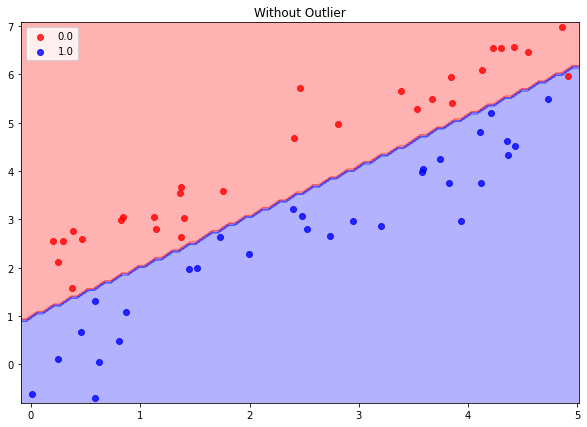

In [211]:
X,y = make_2class_data(outlier=False)
lc = LinearClassifier()
lc.fit(X,y)
plot_classifier(X,y,lc,title="Without Outlier")

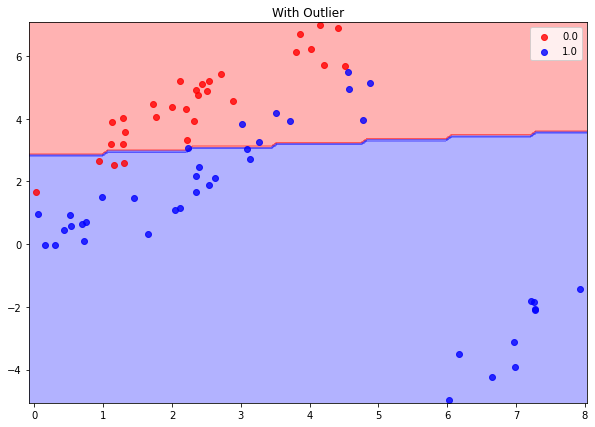

In [212]:
X,y = make_2class_data(outlier=True)
lc = LinearClassifier()
lc.fit(X,y)
plot_classifier(X,y,lc,title="With Outlier")

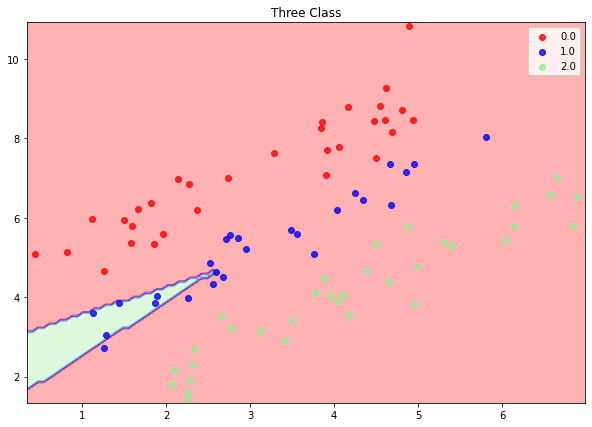

In [225]:
# bug 
X,y = make_3class_data()
lc = LinearClassifier()
lc.fit(X,y)
y_pred = lc.predict(X)
plot_classifier(X,y,lc,title="Three Class")